# Example 1: running GLMsingle on an example session from the Natural Scenes Dataset; comparing voxel reliability across versions

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join, exists
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

# Step 1: load fMRI dataset

In [2]:
homedir = f'/lab_data/tarrlab/jacobpri/GLMsingle'

datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

datafn = join(datadir,'nsdcoreexampledataset.mat')

In [38]:
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    # NSD core experiment, subject 1, session 1, one slice of the fMRI volume. 750 trials total
    dataurl = 'https://osf.io/k89b2/download'
    
    #file = urllib.urlretrieve()
    urllib.request.urlretrieve(dataurl, datafn)
    
# load it
X = sio.loadmat(datafn)

stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]

ROI = X['ROI']

In [4]:
data = []
design = []

for r in range(len(X['data'][0])):
    temp = copy.deepcopy(X['data'][0,r])
    data.append(temp)
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
print(data[0].shape)

(145, 186, 1, 300)


# visualize data and design matrix

In [6]:
print(f'data has {len(data)} runs')
print(f'shape of data from each run is: {data[0].shape}')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only)')
print(f'n = {data[0].shape[3]} TRs per run')
print(f'type of data is: {type(data[0][0,0,0,0])}')

data has 12 runs
shape of data from each run is: (145, 186, 1, 300)
XYZ dimensionality is: (145, 186, 1) (one slice only)
n = 300 TRs per run
type of data is: <class 'numpy.float32'>


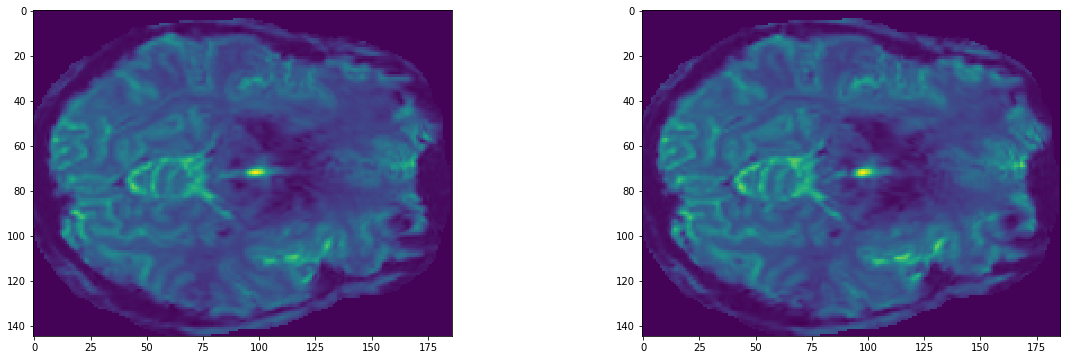

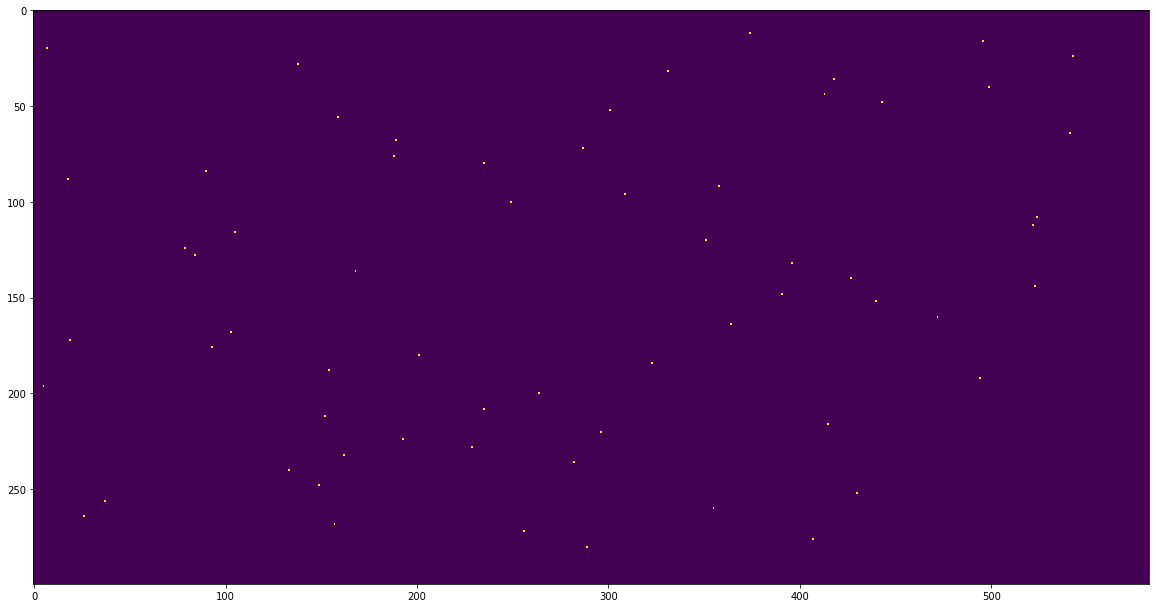

In [7]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,0,0])
plt.subplot(122)
plt.imshow(data[10][:,:,0,0])

plt.figure(figsize=(20,20))
plt.imshow(design[0])

# Step 2: Run baseline GLM (canonical HRF and no optimizations) using GLMsingle

In [8]:
outputdir = join(homedir,'examples','example1outputs')

opt = dict()
opt['wantlibrary'] = 0
opt['wantglmdenoise'] = 0
opt['wantfracridge'] = 0
opt['wantfileoutputs'] = [0,0,0,0]
opt['wantmemoryoutputs'] = [1,1,0,0]

start_time = time.time()
gst_assumehrf = GLM_single(opt)

print(gst_assumehrf.params)

{'wantlibrary': 0, 'wantglmdenoise': 0, 'wantfracridge': 0, 'wantfileoutputs': [0, 0, 0, 0], 'wantmemoryoutputs': [1, 1, 0, 0], 'numforhrf': 50, 'hrfthresh': 0.5, 'hrffitmask': 1, 'R2thresh': 0, 'hrfmodel': 'optimise', 'n_jobs': 1, 'n_pcs': 10, 'n_boots': 100, 'extra_regressors': False, 'chunklen': 45000, 'wantparametric': 0, 'wantpercentbold': 1, 'wantlss': 0, 'brainthresh': [99.0, 0.1], 'brainR2': [], 'brainexclude': False, 'pcR2cutoff': [], 'pcR2cutoffmask': 1, 'pcstop': 1.05, 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]), 'wantautoscale': 1, 'seed': 1621913855.880803, 'suppressoutput': 0, 'lambda': 0}


In [9]:
# run GLMsingle
results_assumehrf = gst_assumehrf.fit(
   design,
   data,
   stimdur,
   tr,
   outputdir=outputdir)

elapsed_time = time.time() - start_time
print(
    'elapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)


*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.2939225693487617 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 1/1 [00:10<00:00, 10.72s/it]

*** All model types done ***

*** return model types in results ***

elapsed time:  00:00:20


In [10]:
print(results_assumehrf['typeb']['betasmd'].shape)

(145, 186, 1, 750)


In [11]:
# Step 3: Visualize baseline GLM outputs

In [12]:
R2 = results_assumehrf['typea']['onoffR2'].reshape((145,186))

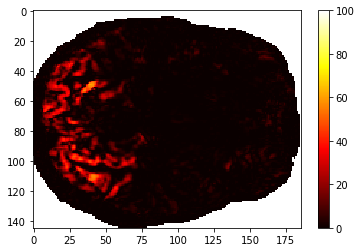

In [13]:
plt.imshow(R2,aspect='auto',clim=(0,100),cmap='hot')
plt.colorbar()

In [16]:
# Step 4: Run GLMsingle with optimizations (library of HRFs, GLMdenoise, fractional ridge regression)

In [17]:
data = []
design = []

for r in range(len(X['data'][0])):
    temp = copy.deepcopy(X['data'][0,r])
    data.append(temp[:,:])
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
print(data[0].shape)

(145, 186, 1, 300)


In [18]:
print(data[0].shape)

(145, 186, 1, 300)


In [19]:

opt = dict()
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

start_time = time.time()
gst_glmsingle = GLM_single(opt)
#gst_glmsingle.params['fracs'] = gst_glmsingle.params['fracs'][::4]

print(gst_glmsingle.params)

{'wantlibrary': 1, 'wantglmdenoise': 1, 'wantfracridge': 1, 'wantfileoutputs': [1, 1, 1, 1], 'wantmemoryoutputs': [1, 1, 1, 1], 'numforhrf': 50, 'hrfthresh': 0.5, 'hrffitmask': 1, 'R2thresh': 0, 'hrfmodel': 'optimise', 'n_jobs': 1, 'n_pcs': 10, 'n_boots': 100, 'extra_regressors': False, 'chunklen': 45000, 'wantparametric': 0, 'wantpercentbold': 1, 'wantlss': 0, 'brainthresh': [99.0, 0.1], 'brainR2': [], 'brainexclude': False, 'pcR2cutoff': [], 'pcR2cutoffmask': 1, 'pcstop': 1.05, 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]), 'wantautoscale': 1, 'seed': 1621913855.880803, 'suppressoutput': 0, 'lambda': 0}


*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/TYPEA_ONOFF.npy. ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.2939225693487617 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 1/1 [03:27<00:00, 207.14s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]


*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|██████████| 1/1 [00:44<00:00, 44.16s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/TYPEC_FITHRF_GLMDENOISE.npy. ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|██████████| 1/1 [14:04<00:00, 844.76s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***

elapsed time:  00:29:22


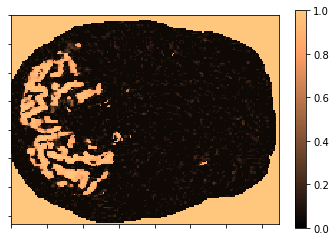

In [20]:
# run GLMsingle
results_glmsingle = gst_glmsingle.fit(
   design,
   data,
   stimdur,
   tr,
   outputdir=outputdir)

elapsed_time = time.time() - start_time
print(
    'elapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)


In [21]:
models = dict()
models['assumehrf'] = results_assumehrf['typeb']['betasmd']
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

In [22]:
# consolidate design matrices
designALL = np.concatenate(design,axis=0)

# compute a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)
corder[:3]

array([374, 496,   7])

In [23]:
repindices = []

for p in range(designALL.shape[1]):
    temp = np.argwhere(corder==p)[:,0]
    #print(temp)
    if len(temp) >= 2:
        repindices.append([temp[0], temp[1]])

repindices = np.vstack(np.array(repindices)).T      
print(repindices[:,:3])

print(f'there are {repindices.shape[1]} repeated conditions in the experiment')

[[216 217  18]
 [485 620 123]]
there are 136 repeated conditions in the experiment


In [40]:
vox_reliabilities = []
modelnames = list(models.keys())

for m in range(len(modelnames)):
    print(modelnames[m])
    time.sleep(1)
    betas = models[modelnames[m]][:,:,:,repindices]
    x,y,z = betas.shape[:3] 
    
    rels = np.full((x,y,z),np.nan)
    
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):
                rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                             betas[xx,yy,zz,1])[1,0]
          
    vox_reliabilities.append(rels)


assumehrf


100%|██████████| 145/145 [00:03<00:00, 40.36it/s]


fithrf


100%|██████████| 145/145 [00:03<00:00, 39.93it/s]


fithrf_glmdenoise


100%|██████████| 145/145 [00:03<00:00, 43.78it/s]


fithrf_glmdenoise_rr


100%|██████████| 145/145 [00:03<00:00, 42.21it/s]


[0.1367562596843417, 0.19053810820081835, 0.19652426770403453, 0.2065344312635405]


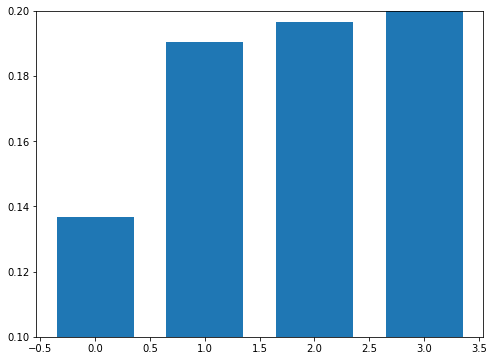

In [50]:
comparison = []
for vr in vox_reliabilities:
    comparison.append(np.nanmean(vr[ROI==1]))

plt.figure(figsize=(8,6))
plt.bar(np.arange(len(comparison)),comparison,width=0.7)
plt.ylim([0.1,0.2])
print(comparison)